In [1]:
from heeps.config import read_config
from heeps.pupil import pupil
from heeps.wavefront import propagate_one
import matplotlib.pyplot as plt
import vip_hci
import numpy as np

In [2]:
conf = read_config()
wf = pupil(**conf)
psf = propagate_one(wf, onaxis=False, **conf)

shift (y, x) = (-14.999893496142661, -4.9999963110012615) (71.99989349614266, 41.99999631100126) (57, 37)
ap_flux = 0.07539425626650267
rim = 13


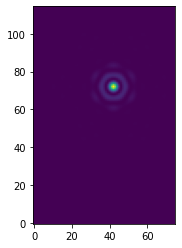

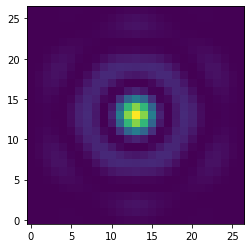

In [3]:
# create a random-size random-center PSF image
psf_OFF = psf[110:-140,140:-150]
(yoff, xoff) = psf_OFF.shape
(cx, cy) = (xoff//2, yoff//2)
plt.imshow(psf_OFF, origin='lower')
# fit a 2D Gaussian --> output: fwhm, x-y centroid
fit = vip_hci.var.fit_2dgaussian(psf_OFF, True, (41,70), debug=False, full_output=True)
#fit = vip_hci.var.fit_2dgaussian(psf_OFF, debug=False, full_output=True)
yerr, xerr = fit['centroid_y_err'].values[0], fit['centroid_x_err'].values[0]
assert (yerr < 0.5) and (xerr < 0.5), 'centroid (x,y) error = '\
                            '(%.1e, %.1e), must be < 0.5 pixel'%(xerr, yerr)
# derive the FWHM
fwhm = np.mean([fit['fwhm_x'], fit['fwhm_y']])
# recenter and crop
shiftx, shifty = cx-fit['centroid_x'].values[0], cy-fit['centroid_y'].values[0]
print('shift (y, x) =', (shifty, shiftx), 
    (fit['centroid_y'].values[0], fit['centroid_x'].values[0]), (cy, cx))
psf_OFF = vip_hci.preproc.frame_shift(psf_OFF, shifty, shiftx)
# FWHM aperture photometry
ap_flux = vip_hci.metrics.aperture_flux(psf_OFF, [cy], [cx], fwhm, verbose=False)[0]
print('ap_flux =', ap_flux)
## image radius (cropped) = 4*FWHM
rim = round(4*fwhm)
psf_OFF_crop = psf_OFF[cy-rim:cy+rim+1, cx-rim:cx+rim+1]
plt.figure();plt.imshow(psf_OFF_crop, origin='lower')
print('rim =', rim)

In [4]:
fit

,centroid_y,centroid_x,fwhm_y,fwhm_x,amplitude,theta,centroid_y_err,centroid_x_err,fwhm_y_err,fwhm_x_err,amplitude_err,theta_err
0,71.999893,41.999996,3.36499,3.365145,0.011927,-0.15821,0.224546,0.224558,0.528766,0.528792,0.001874,2127.805904
